In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

## ETAPA 1 : EDA

In [2]:
# Descargamos el dataframe con información de los municipios
df_muni = pd.read_excel("base_municipios.xlsx")
df_muni.head(5)

,codigo_municipio,municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,poblacion_censo_2010,poblacion_censo_2022
0,1,Adolfo Alsina,3,NOROESTE,3,NOROESTE,Interior,6,5881.6,Javier Andrés,Juntos por el Cambio,17072.0,17552
1,51,Adolfo Gonzáles Cháves,9,SURESTE,8,CENTRO SUR,Interior,6,3788.7,Miriam Lucía Gomez,Juntos por el Cambio,12047.0,12914
2,2,Alberti,2,NORTE,5,CENTRO NORTE,Interior,4,1122.6,Germán Lago,Unión por la Patria,10654.0,12982
3,3,Alte. Brown,5,RMBA,15,RMBA SUR,Conurbano,3,129.3,Mariano Cascallares,Unión por la Patria,552902.0,584827
4,10,Arrecifes,2,NORTE,2,NORTE,Interior,2,1243.8,Juan Fernando Bouvier,Juntos por el Cambio,29044.0,32215


In [3]:
# Descargamos el dataframe con información de los inscriptos al programa
df_insc = pd.read_excel("ficha_inscriptos.xlsx")
df_insc.head(5)

,id,activo,state,criterios_priorizacion,created_at,updated_at,es_duplicado,fecha_solicitud,estado_priorizacion,criterios_aceptacion,...,q_sorteo,etapa_inscripcion,fuente_financiamiento,nro_documentacion_ee,nro_adjudicacion_ee,nro_resolucion_adjudicacion,etapa_cupo_procesamiento,etapa_cupo_liquidacion,external_service_state,nro_respuesta
0,207513,False,desestimado,NaN,2022-10-11 15:32:47,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,503280
1,207649,False,desestimado,NaN,2022-10-11 15:32:51,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,501340
2,208175,False,desestimado,NaN,2022-10-11 15:33:07,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,496204
3,5372,True,no_admisible,NaN,2022-08-31 16:28:43,2023-07-19 10:28:14,False,NaN,0,"--- '[{""valor"":true,""clave"":""Empleado o funcio...",...,0,1,NaN,NaN,NaN,NaN,0.0,0,0,482049
4,5352,True,no_admisible,NaN,2022-08-31 16:28:43,2023-07-19 10:28:14,False,NaN,0,"--- '[{""valor"":true,""clave"":""Empleado o funcio...",...,0,1,NaN,NaN,NaN,NaN,0.0,0,0,482432


In [4]:
# Descargamos el dataframe con información de los formularios completados por los inscriptos
df_form = pd.read_excel("formularios_curso.xlsx")
df_form.head(5)

,fecha_carga,nro_respuesta,version_formulario,sexo_dni,genero,fecha_de_nacimiento,empleado_ivba,beneficiario_procrear,relacion_de_parentezco_con_jefe_del_hogar,municipio,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
0,2022-08-15,473438,Propietarios/as sin cotitulares,F,Mujer,1966-10-30 00:00:00,False,False,Soy jefa(e),Moreno,...,"Construcción de habitación adicional, Construc...",True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,50,2.0
1,2022-08-15,473436,Propietarios/as sin cotitulares,F,Mujer,1982-02-27 00:00:00,False,False,Hija(o),Lanús,...,"Reforma de baño, Construcción y/o reemplazo ab...",False,False,Trabajo independiente,60,Refacciones Mayores - 2.730 UVIs - $ 324.106,2022-08-31 16:56:32,2022-08-31 16:56:32,60,32.0
2,2022-08-15,473435,Propietarios/as sin cotitulares,F,Mujer,1987-08-19 00:00:00,False,False,Hija(o),Alte. Brown,...,"Construcción y/o reforma de cocina, Construcci...",False,False,Otro,25,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,25,1.5
3,2022-08-15,473434,Propietarios/as sin cotitulares,F,Mujer,1986-03-20 00:00:00,False,False,Soy jefa(e),San Pedro,...,"Reforma de baño, Mejoramiento y/o terminacione...",False,True,Otro,80000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,80000,3.5
4,2022-08-15,473433,Propietarios/as sin cotitulares,F,Mujer,1992-09-01 00:00:00,False,False,Soy jefa(e),Gral. Alvarado,...,"Mejoramiento y/o terminaciones en piso, Mejora...",True,True,Trabajo independiente,500000,Refacciones Menores - 1.560 UVIs - $ 185.203,2022-08-31 16:56:32,2022-08-31 16:56:32,500000,3.0


In [5]:
# Concatenamos dataframes por columna
df_evaluate = pd.concat([df_muni, df_insc, df_form], axis=1)

In [6]:
# Chequeamos los nombres de todas las columnas del dataframe concatenado
df_evaluate.columns.tolist()

['codigo_municipio',
 'municipio',
 'codigo_region',
 'nombre_region',
 'codigo_area',
 'nombre_area',
 'conurbano_interior',
 'seccion_electoral',
 'superficie(km2)',
 'intendente',
 'partido_politico_actual',
 'poblacion_censo_2010',
 'poblacion_censo_2022',
 'id',
 'activo',
 'state',
 'criterios_priorizacion',
 'created_at',
 'updated_at',
 'es_duplicado',
 'fecha_solicitud',
 'estado_priorizacion',
 'criterios_aceptacion',
 'control_municipio',
 'control_dcryaiv',
 'fecha_adjudicacion',
 'valor_uvis_adjudicacion',
 'monto_otorgado',
 'fecha_procesamiento',
 'valor_uvis_procesamiento',
 'monto_procesamiento',
 'q_sorteo',
 'etapa_inscripcion',
 'fuente_financiamiento',
 'nro_documentacion_ee',
 'nro_adjudicacion_ee',
 'nro_resolucion_adjudicacion',
 'etapa_cupo_procesamiento',
 'etapa_cupo_liquidacion',
 'external_service_state',
 'nro_respuesta',
 'fecha_carga',
 'nro_respuesta',
 'version_formulario',
 'sexo_dni',
 'genero',
 'fecha_de_nacimiento',
 'empleado_ivba',
 'beneficiari

In [7]:
# Eliminamos columnas prescindibles, como 'municipio'
df_evaluate.drop(['municipio'], axis=1, inplace=True)

## ETAPA 2 : Criterio de selección inicial

In [8]:
# Chequeamos los valores únicos que clasifica etapas de inscripción
df_evaluate['etapa_inscripcion'].unique()

array([2, 1, 3, 4, 5, 6])

In [9]:
# Chequeamos los valores únicos que clasifica estado de la solicitud 
df_evaluate['state'].unique()

array(['desestimado', 'no_admisible', 'admisible_fuera_de_cupo',
       'para_enviar_a_use', 'presentado',
       'solicitud_rechazada_por_falta_de_elegibilidad', 'enviada_a_use',
       'admisible', 'solicitud_adjudicada',
       'solicitud_elegible_rechazada_por_excedente',
       'solicitud_con_adjudicacion_iniciada', 'solicitud_elegible',
       'solicitud_elegible_rechazadas_por_excedente'], dtype=object)

In [10]:
# Filtramos solo los inscriptos en etapa 1
formularios_estudio = df_evaluate[df_evaluate['etapa_inscripcion'] == 1 ]

In [11]:
#Filtramos solo los inscriptos en estado solicitud_adjudicada ó solicitud_elegible_rechazadas_por_excedente 
formularios_estudio[formularios_estudio['state'] == 'solicitud_adjudicada']
formularios_estudio[formularios_estudio['state'] =='solicitud_elegible_rechazadas_por_excedente']


,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
249169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de baño adicional, Construcción d...",True,True,Otro,1000000,Ampliaciones - 6.240 UVIs - $ 1.851.033...,2023-11-21 12:59:08,2023-11-21 12:59:08,1000000,6.000000
249170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Refacción menor de plomería o electricidad, Me...",True,True,Jubilación / Pensión,600,Ampliaciones - 6.240 UVIs - $ 1.851.033...,2023-11-21 12:59:08,2023-11-21 12:59:08,600,2.500000
249171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rampas y/o aberturas para mejoramiento de acce...,True,True,Trabajo en relación de dependencia,2850000,Refacciones Mayores - 3.120 UVIs - $ 92...,2023-11-21 12:59:08,2023-11-21 12:59:08,2850000,2.000000
249172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de baño adicional, Construcción d...",False,True,Trabajo independiente,2112000,Ampliaciones - 3.510 UVIs - $ 1.041.206...,2023-11-21 12:59:08,2023-11-21 12:59:08,2112000,2.500000
249173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Mejoramiento y/o terminaciones en piso, Mejora...",False,True,Trabajo independiente,6000000,"Ampliaciones - 6.240 UVIs - $ 1.851.033,60",2023-11-22 13:52:59,2023-11-22 13:52:59,6000000,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


In [12]:
# Asignamos variable al filtro de los inscriptos en estado solicitud_adjudicada ó solicitud_elegible_rechazadas_por_excedente
filtro = (formularios_estudio['state'] == 'solicitud_adjudicada') | \
         (formularios_estudio['state'] == 'solicitud_elegible_rechazadas_por_excedente')

# Creamos el nuevo dataframe aplicando el filtro
formularios_estudio = formularios_estudio[filtro]

In [13]:
formularios_estudio

,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
58583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de habitación adicional, Construc...",False,True,Trabajo en relación de dependencia,1610000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:23:44,2022-08-31 17:23:44,1610000,2.000000
77090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, C...",True,False,Otro,45000,Ampliaciones - 5.460 UVIs - $ 648.211,2022-08-31 17:30:59,2022-08-31 17:30:59,45000,1.000000
81009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Adaptación de instalaciones sanitarias para me...,True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:32:22,2022-08-31 17:32:22,50,3.000000
110671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Reforma de baño, Construcción de habitación ad...",True,True,Otro,55000,Refacciones Mayores - 3.120 UVIs - $ 417.643,2022-10-11 15:09:29,2022-10-11 15:09:29,55000,4.000000
130628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Construcción de divisiones interiores,False,True,Trabajo en relación de dependencia,1200000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-12 19:28:11,2022-10-12 19:28:11,1200000,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


## ETAPA 3: Cálculo de atributos faltantes


In [14]:
# Cálculo de edad

# Chequeamos la columna 'fecha_carga'
formularios_estudio['fecha_carga']

58583    2022-07-25
77090    2022-07-21
81009    2022-07-20
110671   2022-09-23
130628   2022-10-03
            ...    
250636   2022-12-05
250637   2022-09-29
250638   2022-07-21
250639   2022-09-25
250640   2022-10-17
Name: fecha_carga, Length: 3014, dtype: datetime64[ns]

In [15]:
#Chequeamos la columna 'fecha_de_nacimiento'
formularios_estudio['fecha_de_nacimiento']

58583     1977-09-19 00:00:00
77090     1996-07-28 00:00:00
81009     2003-04-01 00:00:00
110671    1997-09-11 00:00:00
130628    1979-11-16 00:00:00
                 ...         
250636    1980-04-07 00:00:00
250637    1975-03-14 00:00:00
250638    1976-08-11 00:00:00
250639    1987-01-24 00:00:00
250640    1990-12-12 00:00:00
Name: fecha_de_nacimiento, Length: 3014, dtype: object

In [16]:
# Como los valores de cada columna son de distinto tipo de dato, transformamos 'fecha_de_nacimiento' para poder operar 
formularios_estudio['fecha_de_nacimiento'] = pd.to_datetime(
    formularios_estudio['fecha_de_nacimiento'], 
    errors='coerce'
)

In [17]:
# Normalizamos quitando hora/minutos/segundo
formularios_estudio['fecha_de_nacimiento'] = formularios_estudio['fecha_de_nacimiento'].dt.normalize()

In [18]:
# Obtenemos la diferencia entre 'fecha_de_nacimiento' y 'fecha_carga'
edad =  (formularios_estudio['fecha_carga'] - formularios_estudio['fecha_de_nacimiento']).dt.days
edad

58583     16380.0
77090      9489.0
81009      7050.0
110671     9143.0
130628    15662.0
           ...   
250636    15582.0
250637    17366.0
250638    16780.0
250639    13028.0
250640    11632.0
Length: 3014, dtype: float64

In [19]:
#df_inscriptos_etapa_1['edad'] = edad // 365.25
formularios_estudio['edad'] = (edad // 365.25)

# Convertir la columna 'edad' a tipo entero y mantiene valores NA
formularios_estudio['edad'] = pd.to_numeric(formularios_estudio['edad'], errors='coerce').astype('Int64')

In [20]:
formularios_estudio['edad']

58583     44
77090     25
81009     19
110671    25
130628    42
          ..
250636    42
250637    47
250638    45
250639    35
250640    31
Name: edad, Length: 3014, dtype: Int64

## ETAPA 4 : Renombramiento

#### Crear una fila nueva cuyos elementos organice la columna 'state' en dos condiciones: si el valor es 'solicitud_adjudicada', se llamará "Tratamiento", de lo contrario, se llamará "Control" (es decir, los valores 'desestimado', 'no_admisible', 'admisible_fuera_de_cupo''para_enviar_a_use', 'presentado','solicitud_rechazada_por_falta_de_elegibilidad', 'enviada_a_use','admisible' 'solicitud_elegible_rechazada_por_excedente','solicitud_con_adjudicacion_iniciada' 'solicitud_elegible''solicitud_elegible_rechazadas_por_excedente', estarán en este último grupo).

In [21]:
# Hacemos cálculos estadísticos básicos sobre la columna 'ingreso_anual_hogar'
ejemplo_agrupaciones_2 = formularios_estudio['ingreso_anual_hogar'].agg(
    cantidad='count',
    media_ing='mean',
    max_ing='max',
    min_ing='min',
    desvio_ing='std'
).to_frame().T

In [22]:
ejemplo_agrupaciones_2

,cantidad,media_ing,max_ing,min_ing,desvio_ing
ingreso_anual_hogar,3014.0,2.649338e+06,243687983.0,1.0,5.179040e+06


In [23]:
# Calculamos el coeficiente de variación
ejemplo_agrupaciones_3 = formularios_estudio['ingreso_anual_hogar'].agg(
    cantidad='count',
    media_ing='mean',
    desvio_ing='std',
).to_frame().T

In [24]:
ejemplo_agrupaciones_3['%desv_ing'] = (ejemplo_agrupaciones_3['desvio_ing'] / ejemplo_agrupaciones_3['media_ing'] * 100).round(1)

In [25]:
ejemplo_agrupaciones_3

,cantidad,media_ing,desvio_ing,%desv_ing
ingreso_anual_hogar,3014.0,2.649338e+06,5.179040e+06,195.5


In [26]:
# el desvío estándar es mucho mayor que la media.

In [27]:
# Calcula la proporción de género femenino
ejemplo_agrupaciones_4 = pd.DataFrame({
    '%sexo_f': [(formularios_estudio['sexo_dni'] == 'F').mean()]
})


In [28]:
ejemplo_agrupaciones_4


,%sexo_f
0,0.589582


In [29]:
#Análisis total

# Implementamos una función para el cálculo de media y desviación estándar
def calcular_media_std(df:pd.DataFrame, columna:str):
    return (
        f'La media de {columna} es {float(round(df[columna].mean(skipna=True), 1))} ',
        f'La desviación estándar de {columna} es {float(round((df[columna].std(skipna=True)), 1))}'
    )

In [30]:
calcular_media_std(formularios_estudio, 'ingreso_anual_hogar')

('La media de ingreso_anual_hogar es 2649338.4 ',
 'La desviación estándar de ingreso_anual_hogar es 5179040.3')

In [31]:
calcular_media_std(formularios_estudio, 'edad')

('La media de edad es 38.9 ', 'La desviación estándar de edad es 10.9')

In [32]:
calcular_media_std(formularios_estudio, 'personas_por_ambiente')

('La media de personas_por_ambiente es 2.4 ',
 'La desviación estándar de personas_por_ambiente es 2.8')

In [33]:
# Implementamos una función para el cálculo de media bajo una condición

def calcular_media_condicion(df: pd.DataFrame, columna: str, condicion: str):
    proporcion = (df[columna] == condicion).mean(skipna=True)
    print(f" La proporción de la media de {condicion} en {columna} es {round(proporcion, 1)}")
    return round(float(proporcion), 1)


In [34]:
calcular_media_condicion(formularios_estudio,'sexo_dni', 'F')
calcular_media_condicion(formularios_estudio, 'sexo_dni', 'M')
calcular_media_condicion(formularios_estudio, 'relacion_de_parentezco_con_jefe_del_hogar', 'Soy jefa(e)')
calcular_media_condicion(formularios_estudio, 'conurbano_interior', 'Conurbano')

 La proporción de la media de F en sexo_dni es 0.6
 La proporción de la media de M en sexo_dni es 0.4
 La proporción de la media de Soy jefa(e) en relacion_de_parentezco_con_jefe_del_hogar es 0.6
 La proporción de la media de Conurbano en conurbano_interior es 0.0


0.0

In [35]:
#Chequeamos el motivo que de la proporción de la media en 'conurbano_interior'es 0.0
(formularios_estudio['conurbano_interior'] == 'Conurbano').value_counts()


conurbano_interior
False    3014
Name: count, dtype: int64

In [36]:
vuln = float(round(formularios_estudio['escenario_vulnerabilidad_social'].mean(skipna=True), 1))
vuln

0.2

In [37]:
# Se agrupa en 'Tratamiento' si se cumple 'solicitud_adjudicada', y 'control', en caso contrario
formularios_estudio['grupo'] = np.where( formularios_estudio['state'] == 'solicitud_adjudicada','Tratamiento', 'Control')

formularios_estudio['grupo']

58583     Tratamiento
77090     Tratamiento
81009     Tratamiento
110671    Tratamiento
130628    Tratamiento
             ...     
250636        Control
250637        Control
250638        Control
250639        Control
250640        Control
Name: grupo, Length: 3014, dtype: object

In [38]:
# Guardar extracción de datos en "Control" o "Tratamiento"
grupo_control = (formularios_estudio['grupo']) == 'Control' # es una serie que devuelve booleanos
grupo_tratamiento = (formularios_estudio['grupo']) == 'Tratamiento' # idem

In [39]:
# A cada grupo le damos estructura de dataframe nuevo
df_control = formularios_estudio[grupo_control]
df_tratamiento = formularios_estudio[grupo_tratamiento]

In [40]:
# Se eliminan columnas innecesarias en ambos dataframes
df_control_clean = df_control.drop(columns=[
    'codigo_municipio', 'codigo_region', 'nombre_region', 'codigo_area',
    'nombre_area', 'conurbano_interior', 'seccion_electoral',
    'superficie(km2)', 'intendente', 'partido_politico_actual', 
    'poblacion_censo_2010', 'poblacion_censo_2022'
])

In [41]:
df_tratamiento_clean = df_tratamiento.drop(columns=[
    'codigo_municipio', 'codigo_region', 'nombre_region', 'codigo_area',
    'nombre_area', 'conurbano_interior', 'seccion_electoral',
    'superficie(km2)', 'intendente', 'partido_politico_actual', 
    'poblacion_censo_2010', 'poblacion_censo_2022'
])

In [42]:
# Creamos nueva función que calcula media y desviación estándar

def calcular_media_std_1(df: pd.DataFrame, columna:str):
    media = round(df[columna].mean(skipna=True),1)
    std = round(df[columna].std(skipna=True),1)
    return media, std

In [43]:
# Creamos una función que utiliza el cálculo anterior, y transformaciones a dataframe
def calcular_media_std_lista(df: pd.DataFrame, lista: list):
    resultados = {}
    for columna in lista:
        media, std = calcular_media_std_1(df, columna)
        resultados[f'media_{columna}'] = media
        resultados[f'desv_{columna}'] = std
    return pd.DataFrame([resultados]) # pandas necesita lista de diccionarios
    

In [44]:
lista = ['ingreso_anual_hogar', 'edad', 'personas_por_ambiente']
calcular_media_std_lista(df_tratamiento_clean, lista)

,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,2368529.3,6601576.0,39.3,11.6,2.4,2.5


In [45]:
lista = ['ingreso_anual_hogar', 'edad', 'personas_por_ambiente']
calcular_media_std_lista(df_control_clean, lista)

,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,2943501.1,3019208.7,38.4,10.1,2.5,3.0


In [46]:
def calcular_media_condicion(df: pd.DataFrame, dict_condiciones: dict):
    resultado = {}
    for columna, lista_condiciones in dict_condiciones.items():
        for condicion in lista_condiciones:
            proporcion = (df[columna] == condicion).mean(skipna=True)
            resultado[f'media_{columna}_{condicion}'] = round(proporcion,1)
    return pd.DataFrame([resultado])


In [47]:
dict_condiciones = {
    'sexo_dni': ['F','M'],
    'relacion_de_parentezco_con_jefe_del_hogar': ['Soy jefa(e)']
}

calcular_media_condicion(df_tratamiento_clean, dict_condiciones)

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e)
0,0.6,0.4,0.7


In [48]:
calcular_media_condicion(df_control_clean, dict_condiciones)

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e)
0,0.6,0.4,0.5


In [49]:
# Resetear los índices de cada dataframe por muestra

In [50]:
# Grupo tratamiento

df_media_tratamiento = calcular_media_condicion(df_tratamiento_clean, dict_condiciones)
df_media_std_tratamiento = calcular_media_std_lista(df_tratamiento_clean,lista)

df1 = df_media_tratamiento.reset_index(drop=True)
df2 = df_media_std_tratamiento.reset_index(drop=True)

In [51]:
df_tratamiento_total = pd.concat([df1, df2], axis=1)

In [52]:
df_tratamiento_total

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,0.6,0.4,0.7,2368529.3,6601576.0,39.3,11.6,2.4,2.5


In [53]:
# Grupo control

df_media_control = calcular_media_condicion(df_control_clean, dict_condiciones)
df_media_std_control = calcular_media_std_lista(df_control_clean,lista)

df3 = df_media_control.reset_index(drop=True)
df4 = df_media_std_control.reset_index(drop=True)

In [54]:
df_control_total = pd.concat([df3, df4], axis=1)

In [55]:
df_control_total

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,0.6,0.4,0.5,2943501.1,3019208.7,38.4,10.1,2.5,3.0


In [56]:
df_analisis = pd.concat([df_tratamiento_total, df_control_total], axis=0)

In [57]:
df_analisis

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,0.6,0.4,0.7,2368529.3,6601576.0,39.3,11.6,2.4,2.5
0,0.6,0.4,0.5,2943501.1,3019208.7,38.4,10.1,2.5,3.0


In [58]:
vuln_control = float(round(df_control_clean['escenario_vulnerabilidad_social'].mean(skipna=True), 1))
vuln_control

0.1

In [59]:
fila_vuln_c = pd.DataFrame({'escenario_vulnerabilidad_social': [vuln_control]}, index= [1])
fila_vuln_c

,escenario_vulnerabilidad_social
1,0.1


In [60]:
vuln_tratamiento = float(round(df_tratamiento_clean['escenario_vulnerabilidad_social'].mean(skipna=True), 1))
vuln_tratamiento

0.2

In [61]:
fila_vuln_t = pd.DataFrame({'escenario_vulnerabilidad_social': [vuln_tratamiento]}, index= [1])
fila_vuln_t

,escenario_vulnerabilidad_social
1,0.2


In [62]:
df_vuln = pd.concat([fila_vuln_t, fila_vuln_c], axis=0)

In [63]:
df_analisis = df_analisis.reset_index(drop=True)

In [64]:
df_vuln = df_vuln.reset_index(drop=True)

In [65]:
df_analisis_total = pd.concat([df_analisis, df_vuln], axis= 1)

In [66]:
df_analisis_total

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social
0,0.6,0.4,0.7,2368529.3,6601576.0,39.3,11.6,2.4,2.5,0.2
1,0.6,0.4,0.5,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1


In [67]:
# Agregamos una columna nueva para aclarar las muestras
df_analisis_total.insert(loc=0, column='Grupo', value=['Tratamiento', 'Control'])


In [68]:
df_analisis_total

,Grupo,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social
0,Tratamiento,0.6,0.4,0.7,2368529.3,6601576.0,39.3,11.6,2.4,2.5,0.2
1,Control,0.6,0.4,0.5,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1


## ETAPA 5: PLOTS

###  Plot : "Distribución de edad por estado"
    x = "Edad",
    y = "Frecuencia"

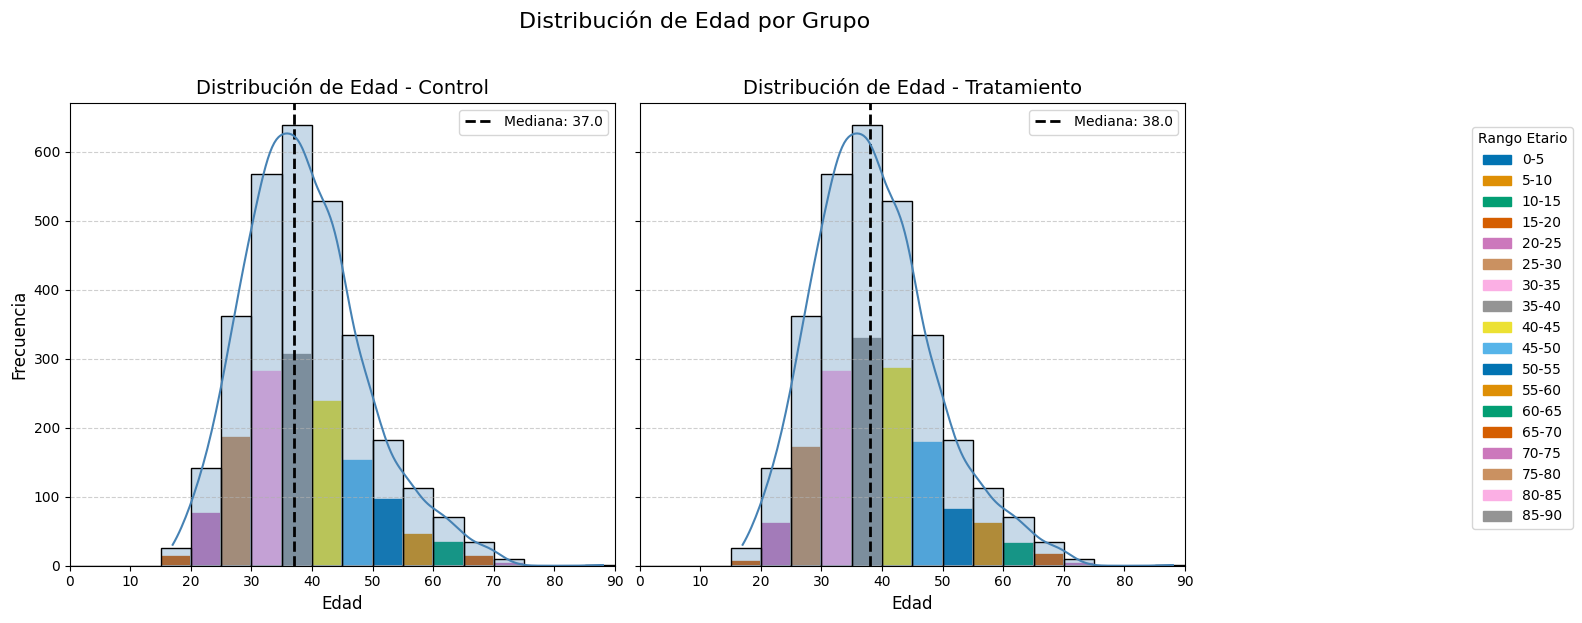

In [90]:
# Configurar bins
bins = np.arange(0, 95, 5)
bin_labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Paleta categórica apta para daltónicos
palette = sns.color_palette("colorblind", len(bins) - 1)

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
grupos = ['Control', 'Tratamiento']

# Limpiar valores fuera del rango lógico (0 a 100)
formularios_estudio = formularios_estudio[(formularios_estudio['edad'] >= 0) & (formularios_estudio['edad'] <= 100)]

for i, grupo in enumerate(grupos):
    ax = axes[i]
    subset = formularios_estudio[formularios_estudio['grupo'] == grupo]
    edades = subset['edad']

    # Asignar edades a bins
    bin_indices = np.digitize(edades, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(palette) - 1)  # Evitar out of range
    
    # Contar frecuencias por bin
    counts = np.zeros(len(bins) - 1)
    for idx in bin_indices:
        counts[idx] += 1
    
    # Dibujar barras para asignar color categórico
    for j, count in enumerate(counts):
        ax.bar(bins[j], count, width=5, align='edge',
               color=palette[j], edgecolor='white', linewidth=1.2)
    
    # mediana
    mediana = np.median(edades)
    ax.axvline(mediana, color='black', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f}')
    
    # Estética
    ax.set_title(f'Distribución de Edad - {grupo}', fontsize=14)
    ax.set_xlabel('Edad', fontsize=12)
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0, 95, 10))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel('Frecuencia', fontsize=12)
    ax.legend(frameon=True)

# Crear leyenda de colores por bin
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(bin_labels))]
fig.legend(handles, bin_labels, title='Rango Etario', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Título
plt.suptitle('Distribución de Edad por Grupo', fontsize=16, y=1.03)
plt.tight_layout()
plt.subplots_adjust(right=0.85)

sns.histplot(formularios_estudio['edad'], bins=bins, kde=True,  color='steelblue',ax=axes[0], alpha=0.3, label= 'Distribución Total')
sns.histplot(formularios_estudio['edad'], bins=bins, kde=True, color='steelblue',ax=axes[1], alpha=0.3, label= 'Distribución Total')

plt.show()
